In [1]:
import string
from os import listdir
from pickle import dump
from numpy import array
from pickle import load
from numpy import argmax
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

import keras
import tensorflow

from keras.layers.merge import add
from keras.utils import to_categorical
from keras.models import Model, load_model
#from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

### 1. Process & Prepare Image Data
- Use pre-trained VGG Model (expects 224 x 224 input).
- use it in advance to pre-compute the image features save them to file (internal representation).
- outputs a 1-dimensional 4,096 element vector.
- Load these features and later feed them into our model as dataset. 
- Optimization technique - training our models faster and consume less memory.

In [2]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = InceptionV3(weights='imagenet')

    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    model.summary()

    # extract features from each photo
    features = dict()
    
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))

        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        #print('>%s' % name)
        
    return features

In [3]:
# extract features from all images
directory = 'Flickr8k_Dataset'

features = extract_features(directory)

print('Extracted Features: %d' % len(features))

96116736/96112376 [==============================] - 81s 1us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________

Extracted Features: 8091


#### Save file (extracted features) to disk as pickle


In [4]:
dump(features, open('features.pkl', 'wb'))

### 2. Process & Prepare Text Data


- Load file containing all descriptions

In [5]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [6]:
filename = 'Flickr8k_text/Flickr8k.token.txt'

doc = load_doc(filename)

print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


#### Each photo has a unique identifier used on the photo filename.
- dictionary of photo identifiers: each identifier maps to a list textual descriptions.

In [7]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()

    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()

        # skip all remaining code if len(line) == 1 or 0
        if len(line) < 2:
            continue
            
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]

        image_desc = ' '.join(image_desc)
        
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            
        # store description
        mapping[image_id].append(image_desc)

    return mapping



In [8]:
descriptions = load_descriptions(doc)

print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [9]:
# Sample descriptions

list(descriptions.keys())[:5]
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

#### Clean the description text
- Convert all words to lowercase.
- Remove all punctuation.
- Remove all words that are one character or less in length (e.g. ‘a’).
- Remove all words with numbers in them.

In [10]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)

    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [11]:
# clean descriptions
clean_descriptions(descriptions)

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

#### size of our dataset vocabulary

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [13]:
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


#### Save the dictionary of image identifiers and descriptions disk (descriptions.txt)

In [15]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [16]:
# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

### 3. Loading Data
- The train dataset have been predefined in the Flickr_8k.trainImages.txt files
- The val dataset have been predefined in the Flickr_8k.devImages.txt files

From the file names, extract photo identifiers and descriptions for each set.

In [17]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    # call load_doc: to load doc into memory
    doc = load_doc(filename)
    
    dataset = list()
    
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
            
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
        
    return set(dataset)

#### Load cleaned text descriptions from ‘descriptions.txt‘ for a given set of identifiers 
- Return a dictionary of identifiers to lists of text descriptions.
***
***
- The model generate a caption given a photo one word at a time.
- The sequence of previously generated words will be provided as input.
- Therefore, we will need a `first word` to kick-off the generation process
- And a `last word` to signal the end of the caption.
- So these tokens are added to the loaded descriptions as they are loaded


In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [19]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)

print('Dataset: %d' % len(train))

Dataset: 6000


In [20]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [21]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Load the photo features for a given dataset.

- Train Dataset

In [22]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [23]:
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Photos: train=6000


#### Encode text to numbers (Tokenizer)

The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

In [24]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [25]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


#### Save Tokemizer

In [26]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

#### calculate the maximum number of words in the longest description

In [27]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [28]:
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


#### Encode sequence 

- Each description will be split into words. 
- The model will be provided one word and the photo and generate the next word. 
- Then first 2 words are provided to model with the image to generate next word.

In [29]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

#### train dataset


In [30]:

X1train, X2train, ytrain = create_sequences(tokenizer, 
                                max_length, train_descriptions, train_features, vocab_size)

#### test dataset

In [31]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))


# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))


# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))


# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, 
                            max_length, test_descriptions, test_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


### 4. Model Design

- There are two input arrays to the model: one for photo features and one for the encoded text. 
- There is one output for the model which is the encoded next word in the text sequence.
- The model will output a prediction (word), over all words probability distribution in vocabulary.
***
- The input text is encoded as integers, which will be fed to a word embedding layer. 
- The photo features will be fed directly to another part of the model. 
- Both the feature extractor and sequence processor output a fixed-length vector. 
- These are merged together and processed by a Dense layer to make a final prediction.
***
The output data will therefore be a one-hot encoded version of each word, 
representing an idealized probability distribution with 0 values at all 
word positions except the actual word position, which has a value of 1.

<img src="model.JPG" width="500" height="500">

In [32]:
# define the captioning model
  
# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

### 5. Train Model


In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [34]:
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

In [35]:
# fit model
history = model.fit([X1train, X2train], ytrain, epochs=1, verbose=1,
          callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

9576/9576 [==============================] - 1871s 195ms/step - loss: 5.2574 - val_loss: 4.1939

Epoch 00001: val_loss improved from inf to 4.19389, saving model to model-ep001-loss4.732-val_loss4.194.h5


### 6. Evaluate Model


In [36]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    result = ''
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word

        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

        result += ' ' + word
        
    return result

In [38]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [39]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.404186
BLEU-2: 0.174637
BLEU-3: 0.094607
BLEU-4: 0.031785


### 7. Visualize Model Result

In [40]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# pre-define the max sequence length (from training)
max_length = 34

In [44]:
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = InceptionV3(weights='imagenet')
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature



In [45]:
def view_result(path):
    # load and prepare the photograph
    photo = extract_features(path)
    
    # display image
    x=plt.imread(path)
    plt.imshow(x)
    plt.show()

    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    print(description)

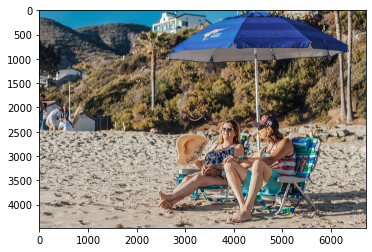

 man in red shirt is sitting on the beach


In [49]:
view_result('img1.jpg')